In [1]:
import pandas as pd
import os 
import matplotlib.pyplot as plt
import sklearn 
import statsmodels.distributions.empirical_distribution as ed 
import seaborn as sns
import numpy as np

Read the CSV and only keep the cortical volume values. 

In [2]:
# read in tadpole data 
tadpole_data = pd.read_csv('tadpole_challenge/TADPOLE_D1_D2.csv', low_memory=False, na_values=' ')
amyloid_data = pd.read_csv('UCBERKELEYAV45_11_14_17.csv')
tadpole_bl_data = tadpole_data[tadpole_data['VISCODE'] == "bl"]
rid_data = tadpole_bl_data['RID']
tadpole_bl_cn_data = tadpole_bl_data[tadpole_bl_data['DX_bl'] == "CN"]
an_data = amyloid_data[amyloid_data['SUMMARYSUVR_WHOLECEREBNORM_1.11CUTOFF'] == 0]
# get the column names containing 'CV' for cortical volume
cv_cols = [x for x in tadpole_data.columns if "CV" in x]
cv_cols = [x for x in cv_cols if 'UCSFFSL' in x]
cv_rid_cols = cv_cols.copy()
#cv_cols = cv_cols.insert(0, 'RID')
cv_rid_cols.insert(0, 'RID')
# get RID of amyloid negative patients
an_rid = an_data['RID']
tadpole_bl_cn_an_data = tadpole_bl_cn_data[tadpole_bl_cn_data['RID'].isin(an_rid)]
bl_cn_an_rid = tadpole_bl_cn_an_data['RID']
#gm_cv_values = gm_values[cv_cols].astype(float)
# normalize the data by dividing by the value in 'ST10CV' for each row and then remove it
#gm_cv_values = gm_cv_values.transpose() / gm_cv_values.ST10CV.values
#gm_cv_values = gm_cv_values.drop(['ST10CV'])

In [3]:
tadpole_bl_cv_data = tadpole_bl_data[cv_rid_cols]
tadpole_bl_cv_data['RID'] = rid_data

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [4]:
#print(tadpole_bl_cv_data.isnull().sum())
#tadpole_bl_cv_data['RID'][tadpole_bl_cv_data.count() == 922]
# 'ST103CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16' is one of the columns for which 922 candidates have data 
not_null_rid = tadpole_bl_cv_data['RID'][tadpole_bl_cv_data['ST103CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16'].notnull()]

Get the idx of the column with high outlying value. 

In [5]:
tadpole_bl_cv_data_final = tadpole_bl_cv_data[tadpole_bl_cv_data['RID'].isin(not_null_rid)]
tadpole_bl_cv_data_final.head()

,RID,ST102CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST103CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST104CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST105CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST106CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST107CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST108CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST109CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST10CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,...,ST85CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST87CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST90CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST91CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST93CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST94CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST95CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST97CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST98CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST99CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16
1,3,3261.0,1936.0,3278.0,2040.0,4299.0,1786.0,6376.0,4034.0,1920690.0,...,8243.0,NaN,11836.0,8550.0,2362.0,13566.0,5892.0,7079.0,4046.0,10097.0
5,4,3082.0,2207.0,2798.0,2863.0,2486.0,1818.0,8672.0,3562.0,1679440.0,...,8787.0,NaN,13683.0,11025.0,1977.0,11379.0,7366.0,7662.0,3925.0,11263.0
10,5,2934.0,2123.0,2749.0,2308.0,3438.0,1320.0,8345.0,3791.0,1640770.0,...,13506.0,NaN,14652.0,10394.0,2176.0,9733.0,7160.0,4811.0,4551.0,10859.0
15,6,2557.0,1627.0,3016.0,2172.0,2589.0,1378.0,6189.0,2862.0,1485830.0,...,8551.0,NaN,13424.0,7304.0,2946.0,11314.0,6732.0,3292.0,2981.0,9572.0
20,7,2769.0,2402.0,2950.0,2511.0,2803.0,1987.0,7619.0,2943.0,1353520.0,...,7145.0,NaN,12812.0,7862.0,1749.0,8950.0,5312.0,6619.0,4073.0,9044.0


In [6]:
empty_cols = list(tadpole_bl_cv_data_final.columns[tadpole_bl_cv_data_final.isnull().sum() > 0])
tadpole_bl_cv_data_final.drop(empty_cols, 1)
tadpole_bl_cv_data.ST10CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16.values
final_colnames = (tadpole_bl_cv_data_final.columns).drop('RID')
tadpole_bl_cv_data_final = tadpole_bl_cv_data_final.astype(float)
tadpole_bl_cv_data_final.shape
#tadpole_bl_cv_data_final[final_colnames] = tadpole_bl_cv_data_final[final_colnames].transpose() / tadpole_bl_cv_data_final.ST10CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16.values

(922, 76)

RID                                                5588.0
ST102CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16     2285.0
ST103CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16     3513.0
ST104CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16     8875.0
ST105CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16      738.0
ST106CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16     1122.0
ST107CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16     9193.0
ST108CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16     4609.0
ST109CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16    10635.0
ST10CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16      3016.0
ST110CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16     3311.0
ST111CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16     3522.0
ST113CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16     4327.0
ST114CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16     3311.0
ST115CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16    10630.0
ST116CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16     3929.0
ST117CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16     5242.0
ST118CV_UCSFFS

In [4]:
gm_cv_values = gm_cv_values.drop(3235,axis=1)

In [9]:
conv2prob_tst = ed.ECDF(gm_cv_values.loc['ST103CV'])(gm_cv_values.loc['ST103CV'])

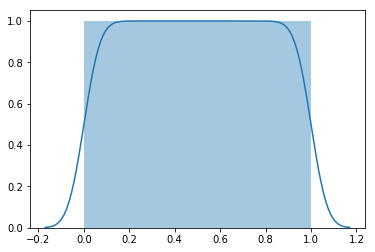

In [10]:
sns.distplot(conv2prob_tst)

In [11]:
print(conv2prob_tst)

[0.45923973 0.36761151 0.40980004 ... 0.98066359 0.28916722 0.61810591]


In [12]:
gm_values.head()

,COLPROT,RID,VISCODE,VISCODE2,EXAMDATE,VERSION,LONISID,LONIUID,IMAGEUID,IMAGETYPE,...,ST147SV,ST148SV,ST149SV,ST150SV,ST151SV,ST152SV,ST153SV,ST154SV,ST155SV,update_stamp
0,ADNI2,21,v11,m84,2012-10-04,2012-10-24,53048,169744,340931,Non-Accelerated T1,...,190930.0,193489.0,384420.0,196942.0,197448.0,394390.0,142785.0,527205.0,869951.0,2016-08-01 11:18:22.0
1,ADNIGO,21,m60,m60,2010-10-08,2012-02-10,29253,93187,222738,Accelerated T1,...,186251.0,188826.0,375077.0,210619.0,208063.0,418682.0,146446.0,521523.0,883558.0,2016-08-01 11:18:22.0
2,ADNIGO,21,m60,m60,2010-10-08,2012-02-10,29253,93190,222684,Non-Accelerated T1,...,191221.0,193313.0,384534.0,205140.0,204958.0,410098.0,146962.0,531496.0,885815.0,2016-08-01 11:18:22.0
3,ADNI2,21,v06,m72,2011-10-13,2012-04-05,38511,125206,265250,Non-Accelerated T1,...,181556.0,184681.0,366238.0,208414.0,209070.0,417484.0,144658.0,510896.0,877214.0,2016-08-01 11:18:22.0
4,ADNI2,21,v21,m96,2013-10-17,2013-12-23,62148,204109,398269,Non-Accelerated T1,...,184176.0,189780.0,373956.0,200248.0,198403.0,398652.0,141727.0,515683.0,860546.0,2016-08-01 11:18:22.0
